<a href="https://colab.research.google.com/github/valentindbdg/Improve-Yolo-Perfomance-Data-Centric-Approach/blob/main/Model_1_P3_model_performance_analysis_and_dataset_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Yolo on Custom Data and Improve Model's Performance Using a Data-centric Approach
##Part 3: Explore dataset and model performance
PROJECT OBJECTIVES

Various tools are used in this notebook to present different ways to visualize, explore and improve data.


##1) Download required packages

In [ ]:
!pip uninstall opencv_python_headless
!pip install opencv-python-headless==4.5.4.60

     |████████████████████████████████| 47.6 MB 2.6 MB/s 


Support for loading confidence from YOLO TXT files was just added in Fiftyone. As a result it was not released yet so a source install of fiftyone is performed to be able to add the confidence in the txt files of the predictions in yolo format. 

https://github.com/voxel51/fiftyone#source-installs-in-google-colab

Note: the runtime has to be restarted after running the following cell:

In [ ]:
%%shell

git clone --depth 1 https://github.com/voxel51/fiftyone.git
cd fiftyone
bash install.bash

Cloning into 'fiftyone'...
remote: Enumerating objects: 916, done.
remote: Counting objects: 100% (916/916), done.
remote: Compressing objects: 100% (853/853), done.
remote: Total 916 (delta 57), reused 479 (delta 26), pack-reused 0
Receiving objects: 100% (916/916), 267.17 MiB | 14.29 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Checking out files: 100% (838/838), done.
***** INSTALLING FIFTYONE-DB *****
     |████████████████████████████████| 29.2 MB 55.8 MB/s 
***** INSTALLING FIFTYONE-APP *****
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13527  100 13527    0     0  35785      0 --:--:-- --:--:-- --:--:-- 35785
=> Downloading nvm from git to '/root/.nvm'
=> Cloning into '/root/.nvm'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (283/283), done.
remote: Total 333 (delta 38), reused 1

## 2) Import datasets and load them into Fiftyone
In this section, both the datasets with ground truth and predictions are imported from disk (google drive) and loaded to Fiftyone

###2.1 Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Copy dataset to local folder
The dataset with both ground truth and prediction (with confidence) labels are copied from the folder saved on the drive during the last run of the previous notebook (Part 2): 

In [ ]:
!cp -av /content/drive/MyDrive/finaldataset/ /content/finaldataset

Streaming output truncated to the last 5000 lines.
'/content/drive/MyDrive/finaldataset/groundtruth/000000224337.txt' -> '/content/finaldataset/groundtruth/000000224337.txt'
'/content/drive/MyDrive/finaldataset/groundtruth/000000234607.txt' -> '/content/finaldataset/groundtruth/000000234607.txt'
'/content/drive/MyDrive/finaldataset/groundtruth/000000414170.txt' -> '/content/finaldataset/groundtruth/000000414170.txt'
'/content/drive/MyDrive/finaldataset/groundtruth/000000036539.txt' -> '/content/finaldataset/groundtruth/000000036539.txt'
'/content/drive/MyDrive/finaldataset/groundtruth/000000105923.txt' -> '/content/finaldataset/groundtruth/000000105923.txt'
'/content/drive/MyDrive/finaldataset/groundtruth/000000283785.txt' -> '/content/finaldataset/groundtruth/000000283785.txt'
'/content/drive/MyDrive/finaldataset/groundtruth/000000074256.txt' -> '/content/finaldataset/groundtruth/000000074256.txt'
'/content/drive/MyDrive/finaldataset/groundtruth/000000341828.txt' -> '/content/finaldat

###2.3 Load dataset into Fiftyone

In [ ]:
import fiftyone as fo
import fiftyone.utils.yolo as fouy

dataset = fo.Dataset.from_dir(
    data_path= "/content/finaldataset/data",
    labels_path="/content/finaldataset/groundtruth",
    dataset_type=fo.types.YOLOv4Dataset,
    label_field="ground_truth",
    classes = 'p'
)

fouy.add_yolo_labels(dataset, "predictions", "/content/finaldataset/predictions", classes = "p")

dataset.persistent = True

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Images file 'None' not found. Listing data directory '/content/finaldataset/data' instead
 100% |███████████████| 2693/2693 [8.8s elapsed, 0s remaining, 333.1 samples/s]       


First, a summary info about the dataset is shown to make sure: 
* "ground_truth" and "predictions" are added to the sample fields; 
* "Num samples" matches the number of images in the dataset.

In [ ]:
print(dataset)

Then, a few samples are shown: 

In [ ]:
print(dataset.head())

Finally, the app is launched to visualize the dataset with both ground truth and predictions of the yolo model. On the samples with predictions, the confidence should be shown as well.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


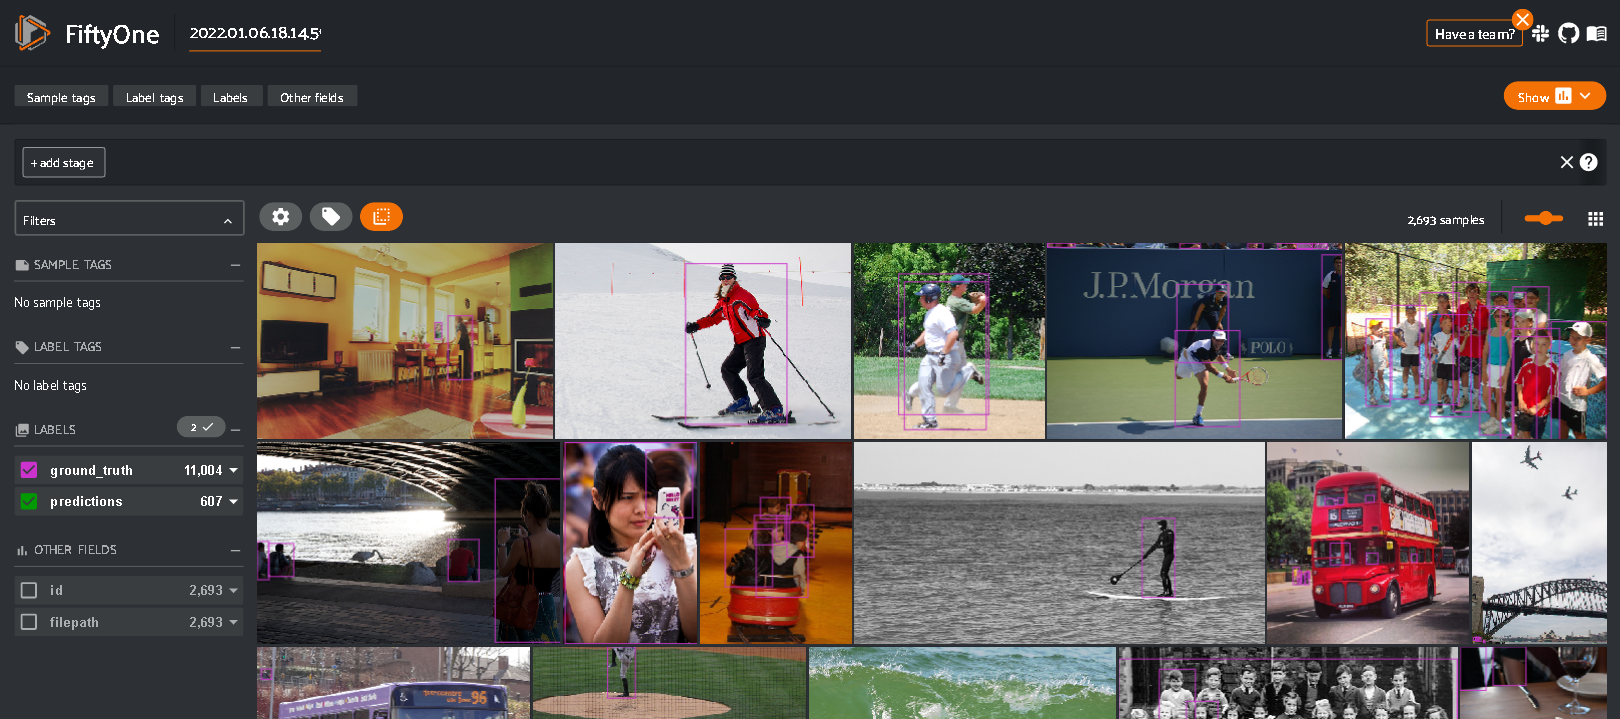

<IPython.core.display.Javascript object>

In [ ]:
session = fo.launch_app(dataset)

A view is created from the dataset:

In [ ]:
predictions_view = dataset.view()

In [ ]:
print(predictions_view)

In [ ]:
session.view = predictions_view

## 3) Confidence thresholding in Python

A view that contains only detections whose `confidence` is superior to `0.001` is created.

In [ ]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = predictions_view.filter_labels("predictions", F("confidence") > 0.001)

In [ ]:
# Print some information about the view
print(high_conf_view)

In [ ]:
# Print a prediction from the view to verify that its confidence is > 0.75
sample = high_conf_view.first()
print(sample.predictions.detections[0])

Now let's load our view in the App to view the predictions that we programmatically selected:

##4) Evaluate detections

FiftyOne is used to evaluate the quality of the model predictions.

### 4.1 Running evaluation

In [ ]:
# Evaluate the predictions in the `predictions` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True, method='open-images' 
)

### Aggregate results
The evaluation routine provides a number of convenient methods for analyzing predictions.

Print statistics about the total TP/FP/FN counts


In [ ]:
print("TP: %d" % dataset.sum("eval_tp"))
print("FP: %d" % dataset.sum("eval_fp"))
print("FN: %d" % dataset.sum("eval_fn"))

Plot a confusion matrix:

In [ ]:
plot2 = results.plot_confusion_matrix(classes=["p"])
plot2.show()

Print a classification report:

In [ ]:
classes = ['p']
results.print_report(classes=classes)

Plot PR Curves:

In [ ]:
plot = results.plot_pr_curves(classes=["p"])
plot.show()

Compute the mean average-precision (mAP) of the detector:

(match what `pycocotools` would report)


In [ ]:
print(results.mAP())

### Sample-level analysis

The evaluation routine also populated some new fields on our dataset that contain helpful information that we can use to evaluate our predictions at the sample-level.

In particular, each sample now contains new fields:

- `eval_tp`: the number of true positive (TP) predictions in the sample
- `eval_fp`: the number of false positive (FP) predictions in the sample
- `eval_fn`: the number of false negative (FN) predictions in the sample

In [ ]:
# Our dataset's schema now contains `eval_*` fields
print(dataset)

The individual predicted and ground truth objects also have fields populated on them describing the results of the matching process:

- `eval`: whether the object is a TP/FP/FN
- `eval_id`: the ID of the matching ground truth/predicted object, if any
- `eval_iou`: the IoU between the matching objects, if any

In [ ]:
# Our detections have helpful evaluation data on them
sample = high_conf_view.first()
print(sample.predictions.detections[0])

These extra fields were added because we provided the ``eval_key`` parameter to [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). If we had omitted this parameter, then no information would have been recorded on our samples.

Don't worry, if you forget what evaluations you've run, you can retrieve information about the evaluation later:

In [ ]:
print(dataset.list_evaluations())

In [ ]:
print(dataset.get_evaluation_info("eval"))

You can even load the view on which you ran an evaluation by calling the [load_evaluation_view()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=load_evaluation_view#fiftyone.core.collections.SampleCollection.load_evaluation_view) method on the parent dataset:

In [ ]:
# Load the view on which we ran the `eval` evaluation
eval_view = dataset.load_evaluation_view("eval")
print(eval_view)

Finally, you can delete an evaluation from a dataset, including any information that was added to your samples, by calling [delete_evaluation()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.delete_evaluation).

### Evaluation views

So, now that we have a sense for the aggregate performance of our model, let's dive into sample-level analysis by creating an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches).

Any evaluation that you stored on your dataset can be used to generate an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches) that is a patches view creating a sample for every true positive, false positive, and false negative in your dataset.
Through this view, you can quickly filter and sort evaluated detections by their type (TP/FP/FN), evaluated IoU, and if they are matched to a crowd object.

These evaluation views can be created through Python or directly in the App as shown below.

In [ ]:
eval_patches = dataset.to_evaluation_patches("eval")
print(eval_patches)

In [ ]:
session.view = high_conf_view

Let's use this evaluation view to find individual false positive detections with a confidence of 0.85 or greater.

In [ ]:
session.view = high_conf_view

### View the best-performing samples

To dig in further, let's create a view that sorts by `eval_tp` so we can see the best-performing cases of our model (i.e., the samples with the most correct predictions):

In [ ]:
# Show samples with most true positives
session.view = high_conf_view.sort_by("eval_tp", reverse=True)

### View the worst-performing samples

Similarly, we can sort by the `eval_fp` field to see the worst-performing cases of our model (i.e., the samples with the most false positive predictions):

In [ ]:
# Show samples with most false positives
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

### Filtering by bounding box area

[Dataset views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) are extremely powerful. For example, let's look at how our model performed on small objects by creating a view that contains only predictions whose bounding box area is less than `32^2` pixels:

In [ ]:
# Compute metadata so we can reference image height/width in our view
dataset.compute_metadata()

In [ ]:
#
# Create an expression that will match objects whose bounding boxes have
# area less than 32^2 pixels
#
# Bounding box format is [top-left-x, top-left-y, width, height]
# with relative coordinates in [0, 1], so we multiply by image
# dimensions to get pixel area
#
bbox_area = (
    F("$metadata.width") * F("bounding_box")[2] *
    F("$metadata.height") * F("bounding_box")[3]
)
small_boxes = bbox_area < 20 ** 2

# Create a view that contains only small (and high confidence) predictions
small_boxes_view = high_conf_view.filter_labels("predictions", small_boxes)

session.view = small_boxes_view

We can always re-run evaluation to see how our detector fairs on only small boxes:

In [ ]:
# Create a view that contains only small GT and predicted boxes
small_boxes_eval_view = (
    high_conf_view
    .filter_labels("ground_truth", small_boxes)
    .filter_labels("predictions", small_boxes)
)

# Run evaluation
small_boxes_results = small_boxes_eval_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
)

In [ ]:
# Get the 10 most common small object classes
#small_counts = small_boxes_eval_view.count_values("ground_truth.detections.label")
#classes_top10_small = sorted(small_counts, key=counts.get, reverse=True)[:10]
classes = ['p']
# Print a classification report for the top-10 small object classes
small_boxes_results.print_report(classes=classes)

### Viewing detections in a crowd

If you're familiar with the [COCO data format](https://cocodataset.org/#format-data), you'll know that the ground truth annotations have an `iscrowd = 0/1` attribute that indicates whether a box contains multiple instances of the same object.

In [ ]:
# View the `iscrowd` attribute on a ground truth object
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '61d731a3f3cc601c641495fb',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'p',
    'bounding_box': BaseList([0.6449995, 0.3699765, 0.082891, 0.323967]),
    'mask': None,
    'confidence': None,
    'index': None,
    'max_iou': 0.0,
}>


Let's create a view that contains only samples with at least one detection for which `iscrowd` is 1:

In [ ]:
# Create a view that contains only samples for which at least one detection has 
# its iscrowd attribute set to 1
crowded_images_view = high_conf_view.match(
    F("ground_truth.detections").filter(F("attributes.iscrowd.value") == 1).length() > 0
)

session.view = crowded_images_view

### More complex insights

Let's combine our previous operations to form more complex queries that provide deeper insight into the quality of our detections.

For example, let's sort our view of crowded images from the previous section in decreasing order of false positive counts, so that we can see samples that have many (allegedly) spurious predictions in images that are known to contain crowds of objects:

In [ ]:
session.view = crowded_images_view.sort_by("eval_fp", reverse=True)

Let's compare the above view to another view that just sorts by false positive count, regardless of whether the image is crowded:

In [ ]:
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

Finally let's open an expanded view of the sample with the most false positive predictions to investigate in more detail:

In [ ]:
session.show()

**See anything interesting?**

What you find will likely be different because a random subset of samples were chosen. In our case, we find missing ground truth boxes for two of the laptop keyboards, a bottle, and even perhaps a cell phone. The model did not confidently predict many of the boxes in this image, but from a high-level, an example like this makes us consider the consequences of including complex or dense images in datasets. It will likely mean incorrect or incomplete ground truth annotations the annotators are not diligent! And that ultimately leads to confused models, and misinformed evaluations.

This conclusion would have been nearly impossible to achieve without visually inspecting the individual samples in the dataset according to the variety of criteria that we considered in this tutorial.

In [ ]:
session.freeze()  # screenshot the active App for sharing

### Tagging and next steps

In practice, the next step is to take action on the issues that we identified above. A natural first step is to *tag* the issues so they can be retrieved and dealt with later. FiftyOne provides support for [tagging samples and labels](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging), both programmatically and via the App.

In your App instance, try tagging the predictions with missing ground truth detections. You can do this by clicking on the boxes of the predictions of interest and using the tagging element in the top-right corner to assign a `possibly-missing` tag.

Alternatively, we can programmatically tag a batch of labels by creating a view that contains the objects of interest and then applying [tag_labels()](https://voxel51.com/docs/fiftyone/user_guide/fiftyone.core.collections.html?highlight=tag_labels#fiftyone.core.collections.SampleCollection.tag_labels):

In [ ]:
# Tag all highly confident false positives as "possibly-missing"
(
    high_conf_view
        .filter_labels("predictions", F("eval") == "fp")
        .select_fields("predictions")
        .tag_labels("possibly-missing")
)

These tagged labels could then be sent off to our annotation provider of choice for review and addition to the ground truth labels. FiftyOne currently offers integrations for [Scale AI](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.scale.html), [Labelbox](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.labelbox.html), and [CVAT](https://voxel51.com/docs/fiftyone/api/fiftyone.types.dataset_types.html?highlight=cvat#fiftyone.types.dataset_types.CVATImageDataset).

For example, the snippet below exports the tagged labels and their source media to disk in CVAT format:

In [ ]:
# Export all labels with the `possibly-missing` tag in CVAT format
(
    dataset
        .select_labels(tags=["possibly-missing"])
        .export("/path/for/export", fo.types.CVATImageDataset)
)

## 3) Compute uniqueness and delete (near) duplicates

In [ ]:
import fiftyone.brain as fob

fob.compute_uniqueness(dataset)

In [ ]:
# Now the samples have a "uniqueness" field on them
print(dataset)

In [ ]:
print(dataset.first())

### 3.1 Select images that are duplicates
Here duplicate or near duplicate images are selected manually in the App

In [ ]:
# Sort the dataset in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness")

# Open view in the App
session.view = dups_view

In [ ]:
#A n id is created for the selected images in the App 
dup_ids = session.selected

# They are marked as duplicates using a tag "dups"
dups_view = dataset.select(dup_ids)
dups_view.tag_samples("dups")

# The duplicates are visualized in the App
session.view = dups_view

###3.1 Delete duplicate images

In [ ]:
#The data with the tag "dups" are deleted
dataset.delete_labels(tags="dups")

# Verify that tagged labels were deleted
print(dataset.count_label_tags())

###3.2 Export duplicated-free dataset

In [ ]:
#!rm -rf "/tmp/fiftyone/image-deduplication" #remove the file from prevous run

dataset.export(label_field="ground_truth",
    export_dir="/content/cleaned-data-yolo",
    dataset_type=fo.types.YOLOv4Dataset,
)

Directory '/content/cleaned-data-yolo' already exists; export will be merged with existing files
 100% |███████████████| 2521/2521 [10.8s elapsed, 0s remaining, 256.5 samples/s]      


In [ ]:
#!rm -rf "/tmp/fiftyone/image-deduplication" #remove the file from prevous run

dataset.export(label_field="ground_truth",
    export_dir="/content/drive/MyDrive/cleaned-data-yolo",
    dataset_type=fo.types.YOLOv4Dataset,
)

Directory '/content/drive/MyDrive/cleaned-data-yolo' already exists; export will be merged with existing files
 100% |███████████████| 2521/2521 [1.1m elapsed, 0s remaining, 46.4 samples/s]      


In [ ]:
#!rm -rf "/tmp/fiftyone/image-deduplication" #remove the file from prevous run

dataset.export(label_field="ground_truth",
    export_dir="/content/drive/MyDrive/cleaned-data-fiftyone",
    dataset_type=fo.types.YOLOv4Dataset,
)

Directory '/content/drive/MyDrive/cleaned-data-fiftyone' already exists; export will be merged with existing files
 100% |███████████████| 2521/2521 [59.7s elapsed, 0s remaining, 50.4 samples/s]      


Reload the new duplicate-free dataset in fiftyone

In [ ]:
dataset = fo.Dataset.from_dir(
    EXPORT_DIR,
    fo.types.FiftyOneImageDetectionDataset,
)

print(dataset)

## 4) Removing duplicate labeling

Now let's use the compute_max_ious() utility to compute the maximum IoU between each object in the ground_truth field with another object of the same class within the same image:

In [ ]:
import fiftyone.utils.eval as foue

foue.compute_max_ious(dataset, "ground_truth", attr_name="max_iou", classwise=True)
print("Max IoU range: (%f, %f)" % dataset.bounds("ground_truth.detections.max_iou"))

 100% |███████████████| 2693/2693 [1.4s elapsed, 0s remaining, 2.0K samples/s]         
Max IoU range: (0.000000, 0.951641)


And load the new dataset back into fiftyone

Dataset:     2022.01.06.18.14.59
Media type:  image
Num samples: 54
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. FilterLabels(field='ground_truth', filter={'$gt': ['$$this.max_iou', 0.5]}, only_matches=True, trajectories=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


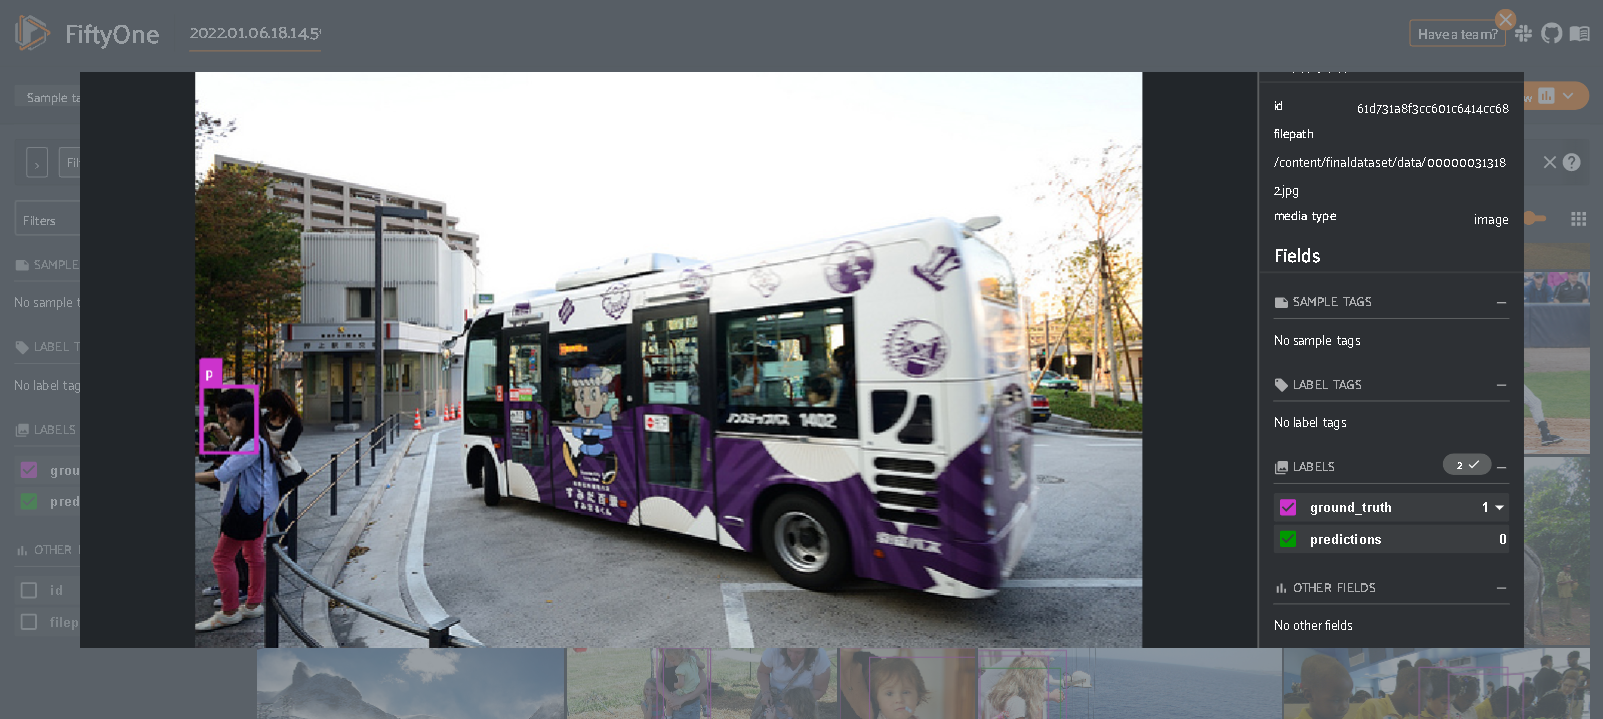

<IPython.core.display.Javascript object>

In [ ]:
from fiftyone import ViewField as F

# Retrieve detections that overlap above a chosen threshold
dups_view = dataset.filter_labels("ground_truth", F("max_iou") > 0.5
                                  )
print(dups_view)
session = fo.launch_app(view=dups_view)

Removing the duplicates with tag "duplicate" added in the session

In [ ]:
dataset.delete_labels(tags="duplicate")

# Verify that tagged labels were deleted


## Tag and delete labels that are "irrelevant", "crowd", or where annotations are "missing"

In [ ]:
session = fo.launch_app(dataset)

Remove the current selected "crowd" labels in the selection 

In [ ]:
dataset.delete_labels(tags="crowd")

Remove samples selected

In [ ]:
sample = session.selected
dataset.delete_samples(sample)




# They are marked as duplicates using a tag "dups"
#dups_view = dataset.select(dup_ids)
#dups_view.tag_samples("dups")

In [ ]:
dataset

Name:        2022.01.06.18.14.59
Media type:  image
Num samples: 2545
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [ ]:
print(dataset.head())

[<Sample: {
    'id': '61d731a3f3cc601c641495fd',
    'media_type': 'image',
    'filepath': '/content/finaldataset/data/000000000139.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61d731a3f3cc601c641495fb',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'p',
                'bounding_box': BaseList([0.6449995, 0.3699765, 0.082891, 0.323967]),
                'mask': None,
                'confidence': None,
                'index': None,
                'max_iou': 0.0,
            }>,
            <Detection: {
                'id': '61d731a3f3cc601c641495fc',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'p',
                'bounding_box': BaseList([0.6006715, 0.4042485, 0.023625, 0.083897]),
                'mask': None,
                'conf

In [ ]:
#anno_key = "duplicate"
#dups_view.annotate(anno_key, label_field="ground_truth", launch_editor=True)

## 5) Sorting by samples with the most number of objects

In [ ]:
from fiftyone import ViewField as F

# Sort samples with the most objects first
obj_count_view = dataset.sort_by(F("ground_truth.detections").length(), reverse=True)

session.view = obj_count_view

##5) Mistakeness

### **5.1.Compute Mistakeness**

Once we have the ground truth and predicted labels added to FiftyOne, we only need to run one command to compute mistakenness.

In [ ]:
import fiftyone.brain as fob

fob.compute_mistakenness(dataset, pred_field="predictions", label_field="ground_truth")

The above method populates a number of fields on the samples of our dataset as well as the ground truth and predicted objects:

New ground truth object attributes (in ground_truth field):

* mistakenness (float): A measure of the likelihood that a ground truth object's label is incorrect
* mistakenness_loc: A measure of the likelihood that a ground truth object's localization (bounding box) is inaccurate
* possible_spurious: Ground truth objects that were not matched with a predicted object and are deemed to be likely spurious annotations will have this attribute set to True

New predicted object attributes (in predictions field):

* possible_missing: If a highly confident prediction with no matching ground truth object is encountered, this attribute is set to True to indicate that it is a likely missing ground truth annotation

Sample-level fields:

* mistakenness: The maximum mistakenness of the ground truth objects in each sample
* possible_spurious: The number of possible spurious ground truth objects in each sample
* possible_missing: The number of possible missing ground truth objects in each sample

### 5.2. Sort the mistakeness 
by likelyhood of mistake (most likely first) and print info about the mistake view:

In [ ]:
from fiftyone import ViewField as F

# Sort by likelihood of mistake (most likely first)
mistake_view = dataset.sort_by("mistakenness", reverse=True)

### 5.3. Print information about mistake_view

In [ ]:
print(mistake_view)

### 5.4. Tagging mistakes


Here we display and directly tag predictions with the tag names: 
- "wrong label" for any prediction wrongly labeled
- "missing" for any predictions without an associated ground truth detection.
- "wrong location" for any prediction with poor location

#### Show samples by mistakenness level:


In [ ]:
# Show the samples we processed in rank order by the mistakenness
session.view = mistake_view

#### Show objects with high mistakenness (> 0.95):

In [ ]:
from fiftyone import ViewField as F

session.view = dataset.filter_labels("ground_truth", F("mistakenness") > 0.95)



####Show objects that may be localized poorly (>0.95):

In [ ]:
session.view = dataset.filter_labels("ground_truth", F("mistakenness_loc") > 0.95)

#### Show objects that may have been missed by annotators:

In [ ]:
session.view = dataset.match(F("possible_missing") > 0)

#### Show samples with the most possible_spurious detections:

In [ ]:
spurious_view = dataset.sort_by("possible_spurious", reverse=True)

session.view= spurious_view

Convert and export the model to a folder in google colab

## 

## 6) Export the new dataset in Yolo format
The dataset is exported in a new format that the model can read (Yolo) and is saved to Google drive

In [ ]:
# Export the labels of interest
dataset.export(
    export_dir="/content/drive/MyDrive/yolo-dataset-full-person",
    dataset_type=fo.types.YOLOv4Dataset,
    classes=classes,
    label_field="ground_truth",
)



Copye the model folders to Google drive to be saved

In [ ]:
%cp -av "/content/yolodataset" "/content/drive/MyDrive"

In [ ]:
# Now load ground truth labels into a new dataset
dataset = fo.Dataset.from_dir(
    dataset_dir="/content/yolodataset",
    dataset_type=fo.types.YOLOv4Dataset,
    label_field="ground_truth",
)

The model is

In [ ]:
# View summary info about the dataset
print(dataset)

In [ ]:
# Print the first few samples in the dataset
print(dataset.head())